# Topographic Similarity
I will use topographic similarity as an indicator for a language's compositionality. I compute it as the pearson correlation between the distances in input and message space of data pairs randomly sampled from the evaluation data. I compute a topographic similarity score for each sender and then average over all senders to get a score for the whole community. Those community scores are then plotted for comparison.

### Loading Packages

In [1]:
import random
import csv
from scipy.spatial import distance
from scipy import stats
import numpy as np
import time
import matplotlib.pyplot as plt

### Defining Needed Functions

In [2]:
'''
def get_csv_line(csv_path, line_idx):
    with open(csv_path, 'r') as f:
        reader = csv.reader(f)
        for i,line in enumerate(reader):
            if i == line_idx:
                output = line
                break
    return output
'''
def get_csv_len(csv_path):
    '''
    Returns the number of lines in a csv file.
    
    Parameter:
        csv_path -- The path to the csv file
        
    Output:
        length -- An int denoting the number of lines in the csv file (count starts at 1)
    '''
    with open(csv_path, 'r') as f:
        reader = csv.reader(f)
        for i,line in enumerate(reader):
            length = i + 1
    return length

### Computing the Community Topographic Similarity Scores

In [3]:
# evaluation of topographic similarities
comm_sizes = [1,2,4]
seeds = [1,2,3,4,5]
'''
# Cosine Similarity not really fitting, Kim & Oh use (1 - HammingDistance)
def similarity_measure(message_1, message_2):
    hamming_distance = distance.hamming(message_1, message_2)
    max_ham_distance = len(message_1)
    normalized_ham_distance = hamming_distance/max_ham_distance
    return (1-normalized_ham_distance)
#similarity_measure = nn.CosineSimilarity(dim=0)
'''

# get the nr of lines in an evaluation dataset, same sizes for different comm sizes
eval_data_len = get_csv_len('./Data/Evaluation_Data/Comm_Size_1/Seed_1/evaluation_data.csv')
# the number of input-message pairs to sample
sample_size = 10000
pairs = []
for i in range(0, sample_size):
    pair_idxs = random.sample(range(1, eval_data_len), k = 2)
    pairs.append(pair_idxs)
    
# list to store the ts scores of all communities
avg_ts_scores = []
ts_scores = []
sender_ts_scores = []

for comm_size in comm_sizes:
    size_ts_scores = []
    avg_size_ts_scores = []
    for seed in seeds:
        eval_data_path = './Data/Evaluation_Data/Comm_Size_'+ str(comm_size) +'/Seed_'+str(seed)+'/evaluation_data.csv'
        sender_scores = []
        with open(eval_data_path, 'r') as eval_data_file:
            # STORING THE CSV DATA IN A LIST IS MUCH MUCH FASTER THAN THE OTHER WAY, POSSIBLE ALSO FOR LARGE CSV??
            eval_data = list(csv.reader(eval_data_file))
            for sender_idx in range(0,comm_size):
                input_distances = []
                message_distances = []
                for pair in pairs:
                    #sample_1 = get_csv_line(eval_data_path, pair[0])
                    #sample_2 = get_csv_line(eval_data_path, pair[1])
                    sample_1 = eval_data[pair[0]]
                    sample_2 = eval_data[pair[1]]

                    #sender_input_str_1 = sample_1[1].replace('[', '').replace('])', '').replace('\n', '')
                    #sender_input_str_2 = sample_2[1].replace('[', '').replace('])', '').replace('\n', '')

                    sender_input_1 = [float(element) for element in sample_1[1].split(',')]
                    sender_input_2 = [float(element) for element in sample_2[1].split(',')]

                    message_1 = [int(element) for element in sample_1[4+sender_idx].split(',')]
                    message_2 = [int(element) for element in sample_2[4+sender_idx].split(',')]

                    input_distance = distance.cosine(sender_input_1, sender_input_2)
                    message_distance = distance.hamming(message_1[:-1], message_2[:-1])
                    input_distances.append(input_distance)
                    message_distances.append(message_distance)

                corr_coeff, _ = stats.pearsonr(input_distances, message_distances)
                sender_scores.append(corr_coeff)
        avg_size_ts_scores.append(np.array(sender_scores).mean())
        size_ts_scores.append(sender_scores)
    avg_ts_scores.append(np.array(avg_size_ts_scores).mean())
    ts_scores.append(avg_size_ts_scores)
    sender_ts_scores.append(size_ts_scores)

In [4]:
print('Average TopSim Scores of all Community Sizes:')
print(avg_ts_scores)
print('TopSim Scores of all Seeds:')
print(ts_scores)
print('TopSim Scores of all Senders:')
print(sender_ts_scores)

Average TopSim Scores of all Community Sizes:
[0.2636740312497007, 0.2309536205190191, 0.2629267271710267]
TopSim Scores of all Seeds:
[[0.2599734489144281, 0.2848150025627295, 0.25690847286098495, 0.2547811642475429, 0.26189206766281786], [0.1963237534172415, 0.22691631601627626, 0.25955827232986983, 0.26029275049657774, 0.21167701033513026], [0.28097985521931546, 0.24388595961050957, 0.2645339923138001, 0.2730743490582893, 0.25215947965321917]]
TopSim Scores of all Senders:
[[[0.2599734489144281], [0.2848150025627295], [0.25690847286098495], [0.2547811642475429], [0.26189206766281786]], [[0.20111934905009643, 0.1915281577843866], [0.2894251116605516, 0.16440752037200093], [0.26328591002257834, 0.25583063463716127], [0.22287454854880218, 0.2977109524443533], [0.21175809372394436, 0.21159592694631613]], [[0.286712542856281, 0.29498610772344086, 0.26563492395205335, 0.27658584634548644], [0.2164709670142363, 0.2475244768208444, 0.25454489978676076, 0.2570034948201968], [0.27792220525199

### Plotting

Text(0, 0.5, 'Topographic Similarity')

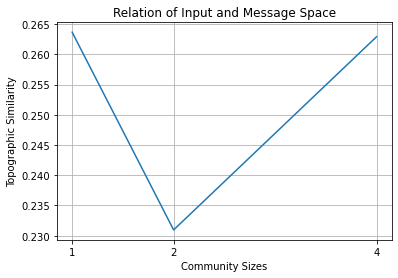

In [5]:
fig, axs = plt.subplots(1,1, sharex = True)
#fig.tight_layout()
plt.subplots_adjust(wspace = 1)
axs.plot(comm_sizes, avg_ts_scores)
axs.grid(True)
axs.set_title('Relation of Input and Message Space')
axs.set_xticks(comm_sizes)
axs.set_xlabel('Community Sizes')
axs.set_ylabel('Topographic Similarity')

### Storing Results

In [6]:
with open('./Data/Results/comm_top_sims.txt', 'a') as file:
    for i,seed_scores in enumerate(ts_scores):
        str_seed_scores = str(seed_scores).replace('[', '').replace(']', '')
        file.write(str_seed_scores + ';' + str(avg_ts_scores[i]) + '\n')

with open('./Data/Results/sender_top_sims.txt', 'a') as file:
    for list_of_sender_topsims in sender_ts_scores:
        file.write(str(list_of_sender_topsims)+'\n')